In [225]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
%matplotlib inline
import lightgbm as lgb
import optuna
import gc
import datetime
import warnings
warnings.filterwarnings('ignore')

# Load data

In [246]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [247]:
display(train.head())
train.shape

,holiday,temperature,rain_in_hour,snow_in_hour,clouds_cover,weather,weather_detail,timestamp,traffic_volume
0,New Years Day,263.49,0.0,0.0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439
1,None,263.78,0.0,0.0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502
2,None,264.16,0.0,0.0,75,Snow,heavy snow,2013-01-01 02:00:00,933
3,None,263.95,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576
4,None,263.65,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372


(37696, 9)

In [202]:
len(train['timestamp'].unique())

31939

In [248]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
train['timestamp']

0       2013-01-01 00:00:00
1       2013-01-01 01:00:00
2       2013-01-01 02:00:00
3       2013-01-01 03:00:00
4       2013-01-01 04:00:00
                ...        
37691   2017-12-31 19:00:00
37692   2017-12-31 20:00:00
37693   2017-12-31 21:00:00
37694   2017-12-31 22:00:00
37695   2017-12-31 23:00:00
Name: timestamp, Length: 37696, dtype: datetime64[ns]

In [249]:
train['DT_month'] = train['timestamp'].dt.month
train['DT_dayofweek'] = train['timestamp'].dt.dayofweek
train['DT_day'] = train['timestamp'].dt.day
train['DT_hour'] = train['timestamp'].dt.hour

display(train.head())
train.shape

,holiday,temperature,rain_in_hour,snow_in_hour,clouds_cover,weather,weather_detail,timestamp,traffic_volume,DT_month,DT_dayofweek,DT_day,DT_hour
0,New Years Day,263.49,0.0,0.0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439,1,1,1,0
1,None,263.78,0.0,0.0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502,1,1,1,1
2,None,264.16,0.0,0.0,75,Snow,heavy snow,2013-01-01 02:00:00,933,1,1,1,2
3,None,263.95,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576,1,1,1,3
4,None,263.65,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372,1,1,1,4


(37696, 13)

In [250]:
test['DT_month'] = test['timestamp'].dt.month
test['DT_dayofweek'] = test['timestamp'].dt.dayofweek
test['DT_day'] = test['timestamp'].dt.day
test['DT_hour'] = test['timestamp'].dt.hour

display(test.head())
test.shape

,holiday,temperature,rain_in_hour,snow_in_hour,clouds_cover,weather,weather_detail,timestamp,DT_month,DT_dayofweek,DT_day,DT_hour
0,New Years Day,249.36,0.0,0.0,1,Clear,sky is clear,2018-01-01 00:00:00,1,0,1,0
1,None,249.08,0.0,0.0,1,Clear,sky is clear,2018-01-01 01:00:00,1,0,1,1
2,None,248.86,0.0,0.0,1,Clear,sky is clear,2018-01-01 02:00:00,1,0,1,2
3,None,248.72,0.0,0.0,1,Clear,sky is clear,2018-01-01 03:00:00,1,0,1,3
4,None,248.43,0.0,0.0,1,Clear,sky is clear,2018-01-01 04:00:00,1,0,1,4


(7949, 12)

In [208]:
train.groupby(['DT_month', 'DT_day'])['holiday'].agg(['count']).reset_index().head()

,DT_month,DT_day,count
0,1,1,89
1,1,2,109
2,1,3,116
3,1,4,102
4,1,5,90


In [251]:
for i in tqdm(range(train.shape[0])):
    if train.iloc[i, 12] == 0:
        holiday = train.iloc[i, 0]
        continue
    else:
        train.iloc[i, 0] = holiday

In [252]:
for i in tqdm(range(test.shape[0])):
    if test.iloc[i, 11] == 0:
        holiday = test.iloc[i, 0]
        continue
    else:
        test.iloc[i, 0] = holiday

In [253]:
train.head(30)

,holiday,temperature,rain_in_hour,snow_in_hour,clouds_cover,weather,weather_detail,timestamp,traffic_volume,DT_month,DT_dayofweek,DT_day,DT_hour
0,New Years Day,263.49,0.0,0.0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439,1,1,1,0
1,New Years Day,263.78,0.0,0.0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502,1,1,1,1
2,New Years Day,264.16,0.0,0.0,75,Snow,heavy snow,2013-01-01 02:00:00,933,1,1,1,2
3,New Years Day,263.95,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576,1,1,1,3
4,New Years Day,263.65,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372,1,1,1,4
5,New Years Day,262.40,0.0,0.0,40,Snow,heavy snow,2013-01-01 05:00:00,419,1,1,1,5
6,New Years Day,261.42,0.0,0.0,20,Clouds,few clouds,2013-01-01 06:00:00,640,1,1,1,6
7,New Years Day,260.66,0.0,0.0,1,Clear,sky is clear,2013-01-01 07:00:00,745,1,1,1,7
8,New Years Day,260.29,0.0,0.0,20,Clouds,few clouds,2013-01-01 08:00:00,939,1,1,1,8
9,New Years Day,260.19,0.0,0.0,20,Clouds,few clouds,2013-01-01 09:00:00,1243,1,1,1,9


In [282]:
import pandas_profiling as pdp

In [283]:
pdp.ProfileReport(train)

In [295]:
train_g = train.groupby(['DT_month', 'DT_day'])['temperature', 'traffic_volume'].agg('mean').reset_index()
train_g.head()

,DT_month,DT_day,temperature,traffic_volume
0,1,1,262.941944,1813.404494
1,1,2,263.844771,2789.541284
2,1,3,265.300371,3270.293103
3,1,4,261.551569,3229.980392
4,1,5,259.373989,2712.188889


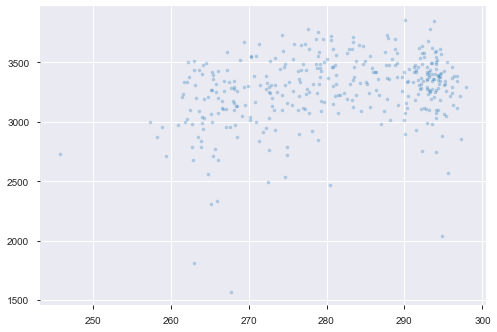

In [296]:
plt.plot(train_g['temperature'], train_g['traffic_volume'], '.', alpha=.3)

In [292]:
a = sorted(train['temperature'].unique())
a

[0.0,
 243.39,
 243.62,
 244.22,
 244.82,
 244.89,
 245.62,
 245.7,
 246.04,
 246.15,
 246.26,
 246.36,
 246.38,
 246.39,
 246.47,
 246.52,
 246.6,
 246.64,
 246.65,
 246.68,
 246.74,
 247.0,
 247.02,
 247.13,
 247.15,
 247.16,
 247.26,
 247.27,
 247.29,
 247.37,
 247.38,
 247.4,
 247.44,
 247.47,
 247.48,
 247.49,
 247.53,
 247.62,
 247.64,
 247.66,
 247.68,
 247.77,
 247.79,
 247.8,
 247.81,
 247.82,
 247.84,
 247.9,
 248.0,
 248.02,
 248.08,
 248.12,
 248.13,
 248.14,
 248.15,
 248.16,
 248.17,
 248.22,
 248.25,
 248.26,
 248.27,
 248.28,
 248.31,
 248.38,
 248.39,
 248.41,
 248.42,
 248.44,
 248.47,
 248.48,
 248.51,
 248.57,
 248.61,
 248.62,
 248.63,
 248.64,
 248.66,
 248.68,
 248.7,
 248.72,
 248.73,
 248.75,
 248.77,
 248.78,
 248.79,
 248.8,
 248.83,
 248.84,
 248.85,
 248.86,
 248.88,
 248.89,
 248.9,
 249.0,
 249.02,
 249.07,
 249.08,
 249.13,
 249.14,
 249.15,
 249.16,
 249.17,
 249.22,
 249.27,
 249.29,
 249.3,
 249.33,
 249.34,
 249.35,
 249.36,
 249.38,
 249.39,
 249.43

In [297]:
train['weather'].unique()

array([ 1,  8,  0,  5,  4,  3,  6,  2, 10,  9,  7])

In [298]:
train['weather_detail'].unique()

array([ 2, 24, 10, 19,  4, 27, 17,  7,  5, 13, 18,  3, 11, 30,  6, 26, 35,
       23,  9, 21, 14, 12,  0, 33, 36,  8, 22, 31,  1, 37, 34, 16, 32, 20,
       29, 25, 15, 28])

# Label encoding

In [254]:
for col in tqdm_notebook(train.columns):
    if train[col].dtype == 'object' and col != 'timestamp' and col != 'traffic_volume':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

# Split to features and target

In [255]:
X = train.drop(['timestamp', 'traffic_volume'], axis=1)
y = train['traffic_volume']
X_test = test.drop(['timestamp'], axis=1)
X.head()

,holiday,temperature,rain_in_hour,snow_in_hour,clouds_cover,weather,weather_detail,DT_month,DT_dayofweek,DT_day,DT_hour
0,6,263.49,0.0,0.0,58,1,2,1,1,1,0
1,6,263.78,0.0,0.0,40,1,24,1,1,1,1
2,6,264.16,0.0,0.0,75,8,10,1,1,1,2
3,6,263.95,0.0,0.0,90,1,19,1,1,1,3
4,6,263.65,0.0,0.0,90,1,19,1,1,1,4


# Construct model

In [266]:
seed = 167

In [257]:
n_fold = 5
kf = TimeSeriesSplit(n_splits=n_fold)
n_train = X.shape[0]
n_test = X_test.shape[0]
n_features = X.shape[1]
feature_importance = pd.DataFrame()
feature_importance['feature'] = X.columns

In [258]:
def objective(trial):
    X_train, y_train = X[:20000], y[:20000]
    X_valid, y_valid = X[20000:], y[20000:]
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    rgr = lgb.train(params, train_data, 1000, valid_sets=valid_data, verbose_eval=100, early_stopping_rounds=10)
    preds = rgr.predict(X_valid, num_iteration=rgr.best_iteration)
    
    #lgb = lgb.train(params, X_train, y_train)
    #preds = lgb.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return rmse

In [267]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)
print(f'Number of finished trials: {len(study.trials)}')
print('Best trials: ')
trial = study.best_trial
print(f'Value: {trial.value}')
print('Params: ')
for key, value in trial.params.items():
    print(f'{key}: {value}')

Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 476.979
[200]	valid_0's rmse: 465.567
Early stopping, best iteration is:
[202]	valid_0's rmse: 465.481


[I 2020-01-01 20:54:53,639] Finished trial#0 resulted in value: 465.4805439223709. Current best value is 465.4805439223709 with parameters: {'lambda_l1': 0.03489641785991414, 'lambda_l2': 1.4402777183537301e-06, 'num_leaves': 85, 'feature_fraction': 0.4500372137359889, 'bagging_fraction': 0.7346162437445779, 'bagging_freq': 3, 'min_child_samples': 85}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 861.492
[200]	valid_0's rmse: 821.514
[300]	valid_0's rmse: 812.457
Early stopping, best iteration is:
[355]	valid_0's rmse: 809.987


[I 2020-01-01 20:54:54,384] Finished trial#1 resulted in value: 809.9869521091489. Current best value is 465.4805439223709 with parameters: {'lambda_l1': 0.03489641785991414, 'lambda_l2': 1.4402777183537301e-06, 'num_leaves': 85, 'feature_fraction': 0.4500372137359889, 'bagging_fraction': 0.7346162437445779, 'bagging_freq': 3, 'min_child_samples': 85}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 447.6
Early stopping, best iteration is:
[126]	valid_0's rmse: 445.41


[I 2020-01-01 20:54:55,078] Finished trial#2 resulted in value: 445.40988391417005. Current best value is 445.40988391417005 with parameters: {'lambda_l1': 7.113761327372718e-07, 'lambda_l2': 0.0001326782344895063, 'num_leaves': 20, 'feature_fraction': 0.6809254294858607, 'bagging_fraction': 0.8179399218232841, 'bagging_freq': 2, 'min_child_samples': 64}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 476.731
Early stopping, best iteration is:
[127]	valid_0's rmse: 470.847


[I 2020-01-01 20:54:56,260] Finished trial#3 resulted in value: 470.84748353425624. Current best value is 445.40988391417005 with parameters: {'lambda_l1': 7.113761327372718e-07, 'lambda_l2': 0.0001326782344895063, 'num_leaves': 20, 'feature_fraction': 0.6809254294858607, 'bagging_fraction': 0.8179399218232841, 'bagging_freq': 2, 'min_child_samples': 64}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 470.636
Early stopping, best iteration is:
[127]	valid_0's rmse: 468.798


[I 2020-01-01 20:54:57,470] Finished trial#4 resulted in value: 468.79831169064926. Current best value is 445.40988391417005 with parameters: {'lambda_l1': 7.113761327372718e-07, 'lambda_l2': 0.0001326782344895063, 'num_leaves': 20, 'feature_fraction': 0.6809254294858607, 'bagging_fraction': 0.8179399218232841, 'bagging_freq': 2, 'min_child_samples': 64}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 552.558
Early stopping, best iteration is:
[127]	valid_0's rmse: 528.707


[I 2020-01-01 20:54:58,970] Finished trial#5 resulted in value: 528.7072306145539. Current best value is 445.40988391417005 with parameters: {'lambda_l1': 7.113761327372718e-07, 'lambda_l2': 0.0001326782344895063, 'num_leaves': 20, 'feature_fraction': 0.6809254294858607, 'bagging_fraction': 0.8179399218232841, 'bagging_freq': 2, 'min_child_samples': 64}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 470.687
Early stopping, best iteration is:
[134]	valid_0's rmse: 467.952


[I 2020-01-01 20:55:00,436] Finished trial#6 resulted in value: 467.9518029893848. Current best value is 445.40988391417005 with parameters: {'lambda_l1': 7.113761327372718e-07, 'lambda_l2': 0.0001326782344895063, 'num_leaves': 20, 'feature_fraction': 0.6809254294858607, 'bagging_fraction': 0.8179399218232841, 'bagging_freq': 2, 'min_child_samples': 64}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 538.012
[200]	valid_0's rmse: 495.701
[300]	valid_0's rmse: 475.104
Early stopping, best iteration is:
[351]	valid_0's rmse: 470.291


[I 2020-01-01 20:55:01,308] Finished trial#7 resulted in value: 470.29096803957026. Current best value is 445.40988391417005 with parameters: {'lambda_l1': 7.113761327372718e-07, 'lambda_l2': 0.0001326782344895063, 'num_leaves': 20, 'feature_fraction': 0.6809254294858607, 'bagging_fraction': 0.8179399218232841, 'bagging_freq': 2, 'min_child_samples': 64}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 444.33
Early stopping, best iteration is:
[97]	valid_0's rmse: 444.018


[I 2020-01-01 20:55:02,037] Finished trial#8 resulted in value: 444.018092521263. Current best value is 444.018092521263 with parameters: {'lambda_l1': 1.7072399226857603e-06, 'lambda_l2': 6.915220417391685e-07, 'num_leaves': 35, 'feature_fraction': 0.6853164535775593, 'bagging_fraction': 0.8755320417025999, 'bagging_freq': 1, 'min_child_samples': 25}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 442.359
Early stopping, best iteration is:
[101]	valid_0's rmse: 442.209


[I 2020-01-01 20:55:02,898] Finished trial#9 resulted in value: 442.20922978741186. Current best value is 442.20922978741186 with parameters: {'lambda_l1': 0.010746531590647488, 'lambda_l2': 0.6161605248317648, 'num_leaves': 42, 'feature_fraction': 0.8070611154094497, 'bagging_fraction': 0.8080541334465734, 'bagging_freq': 4, 'min_child_samples': 81}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[50]	valid_0's rmse: 456.012


[I 2020-01-01 20:55:03,614] Finished trial#10 resulted in value: 456.01221279653817. Current best value is 442.20922978741186 with parameters: {'lambda_l1': 0.010746531590647488, 'lambda_l2': 0.6161605248317648, 'num_leaves': 42, 'feature_fraction': 0.8070611154094497, 'bagging_fraction': 0.8080541334465734, 'bagging_freq': 4, 'min_child_samples': 81}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 444.849
Early stopping, best iteration is:
[115]	valid_0's rmse: 444.036


[I 2020-01-01 20:55:04,605] Finished trial#11 resulted in value: 444.035587830086. Current best value is 442.20922978741186 with parameters: {'lambda_l1': 0.010746531590647488, 'lambda_l2': 0.6161605248317648, 'num_leaves': 42, 'feature_fraction': 0.8070611154094497, 'bagging_fraction': 0.8080541334465734, 'bagging_freq': 4, 'min_child_samples': 81}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 442.964
Early stopping, best iteration is:
[100]	valid_0's rmse: 442.964


[I 2020-01-01 20:55:05,498] Finished trial#12 resulted in value: 442.96403501645284. Current best value is 442.20922978741186 with parameters: {'lambda_l1': 0.010746531590647488, 'lambda_l2': 0.6161605248317648, 'num_leaves': 42, 'feature_fraction': 0.8070611154094497, 'bagging_fraction': 0.8080541334465734, 'bagging_freq': 4, 'min_child_samples': 81}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[72]	valid_0's rmse: 456.028


[I 2020-01-01 20:55:06,346] Finished trial#13 resulted in value: 456.0284342563273. Current best value is 442.20922978741186 with parameters: {'lambda_l1': 0.010746531590647488, 'lambda_l2': 0.6161605248317648, 'num_leaves': 42, 'feature_fraction': 0.8070611154094497, 'bagging_fraction': 0.8080541334465734, 'bagging_freq': 4, 'min_child_samples': 81}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 456.001


[I 2020-01-01 20:55:06,992] Finished trial#14 resulted in value: 456.00141305463364. Current best value is 442.20922978741186 with parameters: {'lambda_l1': 0.010746531590647488, 'lambda_l2': 0.6161605248317648, 'num_leaves': 42, 'feature_fraction': 0.8070611154094497, 'bagging_fraction': 0.8080541334465734, 'bagging_freq': 4, 'min_child_samples': 81}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	valid_0's rmse: 447.711


[I 2020-01-01 20:55:07,658] Finished trial#15 resulted in value: 447.7114333627835. Current best value is 442.20922978741186 with parameters: {'lambda_l1': 0.010746531590647488, 'lambda_l2': 0.6161605248317648, 'num_leaves': 42, 'feature_fraction': 0.8070611154094497, 'bagging_fraction': 0.8080541334465734, 'bagging_freq': 4, 'min_child_samples': 81}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 451.03


[I 2020-01-01 20:55:08,310] Finished trial#16 resulted in value: 451.03032448691056. Current best value is 442.20922978741186 with parameters: {'lambda_l1': 0.010746531590647488, 'lambda_l2': 0.6161605248317648, 'num_leaves': 42, 'feature_fraction': 0.8070611154094497, 'bagging_fraction': 0.8080541334465734, 'bagging_freq': 4, 'min_child_samples': 81}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's rmse: 452.273


[I 2020-01-01 20:55:09,060] Finished trial#17 resulted in value: 452.27328526807185. Current best value is 442.20922978741186 with parameters: {'lambda_l1': 0.010746531590647488, 'lambda_l2': 0.6161605248317648, 'num_leaves': 42, 'feature_fraction': 0.8070611154094497, 'bagging_fraction': 0.8080541334465734, 'bagging_freq': 4, 'min_child_samples': 81}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 446.396
Early stopping, best iteration is:
[105]	valid_0's rmse: 445.927


[I 2020-01-01 20:55:09,854] Finished trial#18 resulted in value: 445.926746581829. Current best value is 442.20922978741186 with parameters: {'lambda_l1': 0.010746531590647488, 'lambda_l2': 0.6161605248317648, 'num_leaves': 42, 'feature_fraction': 0.8070611154094497, 'bagging_fraction': 0.8080541334465734, 'bagging_freq': 4, 'min_child_samples': 81}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[58]	valid_0's rmse: 464.143


[I 2020-01-01 20:55:10,502] Finished trial#19 resulted in value: 464.1432516018181. Current best value is 442.20922978741186 with parameters: {'lambda_l1': 0.010746531590647488, 'lambda_l2': 0.6161605248317648, 'num_leaves': 42, 'feature_fraction': 0.8070611154094497, 'bagging_fraction': 0.8080541334465734, 'bagging_freq': 4, 'min_child_samples': 81}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[71]	valid_0's rmse: 440.684


[I 2020-01-01 20:55:11,116] Finished trial#20 resulted in value: 440.68358099680836. Current best value is 440.68358099680836 with parameters: {'lambda_l1': 0.02347237362890773, 'lambda_l2': 1.5464651015688074e-05, 'num_leaves': 27, 'feature_fraction': 0.9974450690914831, 'bagging_fraction': 0.8357603419746031, 'bagging_freq': 3, 'min_child_samples': 37}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 447.101
Early stopping, best iteration is:
[171]	valid_0's rmse: 440.784


[I 2020-01-01 20:55:11,825] Finished trial#21 resulted in value: 440.7839018518412. Current best value is 440.68358099680836 with parameters: {'lambda_l1': 0.02347237362890773, 'lambda_l2': 1.5464651015688074e-05, 'num_leaves': 27, 'feature_fraction': 0.9974450690914831, 'bagging_fraction': 0.8357603419746031, 'bagging_freq': 3, 'min_child_samples': 37}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 443.825
Early stopping, best iteration is:
[123]	valid_0's rmse: 442.593


[I 2020-01-01 20:55:12,498] Finished trial#22 resulted in value: 442.5934251848736. Current best value is 440.68358099680836 with parameters: {'lambda_l1': 0.02347237362890773, 'lambda_l2': 1.5464651015688074e-05, 'num_leaves': 27, 'feature_fraction': 0.9974450690914831, 'bagging_fraction': 0.8357603419746031, 'bagging_freq': 3, 'min_child_samples': 37}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 729.886
[200]	valid_0's rmse: 618.555
[300]	valid_0's rmse: 588.791
[400]	valid_0's rmse: 566.065
[500]	valid_0's rmse: 546.014
Early stopping, best iteration is:
[527]	valid_0's rmse: 542.696


[I 2020-01-01 20:55:13,328] Finished trial#23 resulted in value: 542.6956318093348. Current best value is 440.68358099680836 with parameters: {'lambda_l1': 0.02347237362890773, 'lambda_l2': 1.5464651015688074e-05, 'num_leaves': 27, 'feature_fraction': 0.9974450690914831, 'bagging_fraction': 0.8357603419746031, 'bagging_freq': 3, 'min_child_samples': 37}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 447.338
Early stopping, best iteration is:
[127]	valid_0's rmse: 445.72


[I 2020-01-01 20:55:14,123] Finished trial#24 resulted in value: 445.72012066338493. Current best value is 440.68358099680836 with parameters: {'lambda_l1': 0.02347237362890773, 'lambda_l2': 1.5464651015688074e-05, 'num_leaves': 27, 'feature_fraction': 0.9974450690914831, 'bagging_fraction': 0.8357603419746031, 'bagging_freq': 3, 'min_child_samples': 37}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 443.669


[I 2020-01-01 20:55:14,705] Finished trial#25 resulted in value: 443.6692477099984. Current best value is 440.68358099680836 with parameters: {'lambda_l1': 0.02347237362890773, 'lambda_l2': 1.5464651015688074e-05, 'num_leaves': 27, 'feature_fraction': 0.9974450690914831, 'bagging_fraction': 0.8357603419746031, 'bagging_freq': 3, 'min_child_samples': 37}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	valid_0's rmse: 444.034


[I 2020-01-01 20:55:15,451] Finished trial#26 resulted in value: 444.03390797680953. Current best value is 440.68358099680836 with parameters: {'lambda_l1': 0.02347237362890773, 'lambda_l2': 1.5464651015688074e-05, 'num_leaves': 27, 'feature_fraction': 0.9974450690914831, 'bagging_fraction': 0.8357603419746031, 'bagging_freq': 3, 'min_child_samples': 37}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 448.655
Early stopping, best iteration is:
[99]	valid_0's rmse: 448.571


[I 2020-01-01 20:55:16,343] Finished trial#27 resulted in value: 448.57143110711667. Current best value is 440.68358099680836 with parameters: {'lambda_l1': 0.02347237362890773, 'lambda_l2': 1.5464651015688074e-05, 'num_leaves': 27, 'feature_fraction': 0.9974450690914831, 'bagging_fraction': 0.8357603419746031, 'bagging_freq': 3, 'min_child_samples': 37}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 524.772
[200]	valid_0's rmse: 486.99
[300]	valid_0's rmse: 470.156
[400]	valid_0's rmse: 462.442
[500]	valid_0's rmse: 454.76
[600]	valid_0's rmse: 451.204
Early stopping, best iteration is:
[602]	valid_0's rmse: 451.153


[I 2020-01-01 20:55:17,443] Finished trial#28 resulted in value: 451.15337307000897. Current best value is 440.68358099680836 with parameters: {'lambda_l1': 0.02347237362890773, 'lambda_l2': 1.5464651015688074e-05, 'num_leaves': 27, 'feature_fraction': 0.9974450690914831, 'bagging_fraction': 0.8357603419746031, 'bagging_freq': 3, 'min_child_samples': 37}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 454.361


[I 2020-01-01 20:55:18,101] Finished trial#29 resulted in value: 454.3609230232526. Current best value is 440.68358099680836 with parameters: {'lambda_l1': 0.02347237362890773, 'lambda_l2': 1.5464651015688074e-05, 'num_leaves': 27, 'feature_fraction': 0.9974450690914831, 'bagging_fraction': 0.8357603419746031, 'bagging_freq': 3, 'min_child_samples': 37}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 442.342
Early stopping, best iteration is:
[103]	valid_0's rmse: 442.109


[I 2020-01-01 20:55:18,762] Finished trial#30 resulted in value: 442.10935709148214. Current best value is 440.68358099680836 with parameters: {'lambda_l1': 0.02347237362890773, 'lambda_l2': 1.5464651015688074e-05, 'num_leaves': 27, 'feature_fraction': 0.9974450690914831, 'bagging_fraction': 0.8357603419746031, 'bagging_freq': 3, 'min_child_samples': 37}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 440.361
Early stopping, best iteration is:
[90]	valid_0's rmse: 440.226


[I 2020-01-01 20:55:19,441] Finished trial#31 resulted in value: 440.2255004894947. Current best value is 440.2255004894947 with parameters: {'lambda_l1': 0.0005497020782899349, 'lambda_l2': 4.715543143581851e-05, 'num_leaves': 29, 'feature_fraction': 0.9435218867142415, 'bagging_fraction': 0.819435151639222, 'bagging_freq': 3, 'min_child_samples': 42}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 440.473
Early stopping, best iteration is:
[156]	valid_0's rmse: 438.104


[I 2020-01-01 20:55:20,183] Finished trial#32 resulted in value: 438.1041198574876. Current best value is 438.1041198574876 with parameters: {'lambda_l1': 0.00036361649865835607, 'lambda_l2': 6.133142716474548e-05, 'num_leaves': 28, 'feature_fraction': 0.9470320793195738, 'bagging_fraction': 0.8552436307423938, 'bagging_freq': 3, 'min_child_samples': 41}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 453.952
[200]	valid_0's rmse: 444.735
Early stopping, best iteration is:
[230]	valid_0's rmse: 442.452


[I 2020-01-01 20:55:20,897] Finished trial#33 resulted in value: 442.4524273243616. Current best value is 438.1041198574876 with parameters: {'lambda_l1': 0.00036361649865835607, 'lambda_l2': 6.133142716474548e-05, 'num_leaves': 28, 'feature_fraction': 0.9470320793195738, 'bagging_fraction': 0.8552436307423938, 'bagging_freq': 3, 'min_child_samples': 41}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 434.394


[I 2020-01-01 20:55:21,542] Finished trial#34 resulted in value: 434.3940723768646. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	valid_0's rmse: 438.269


[I 2020-01-01 20:55:22,241] Finished trial#35 resulted in value: 438.26888680049717. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 442.109


[I 2020-01-01 20:55:22,899] Finished trial#36 resulted in value: 442.108732844674. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	valid_0's rmse: 439.095


[I 2020-01-01 20:55:23,516] Finished trial#37 resulted in value: 439.0949144588604. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 437.179


[I 2020-01-01 20:55:24,131] Finished trial#38 resulted in value: 437.17940292472105. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 513.454
Early stopping, best iteration is:
[167]	valid_0's rmse: 481.494


[I 2020-01-01 20:55:25,167] Finished trial#39 resulted in value: 481.49367197759074. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 480.995
Early stopping, best iteration is:
[131]	valid_0's rmse: 475.817


[I 2020-01-01 20:55:26,181] Finished trial#40 resulted in value: 475.8172827480727. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[54]	valid_0's rmse: 437.973


[I 2020-01-01 20:55:26,831] Finished trial#41 resulted in value: 437.9729923627867. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 442.717


[I 2020-01-01 20:55:27,548] Finished trial#42 resulted in value: 442.7167283625775. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 437.026


[I 2020-01-01 20:55:28,163] Finished trial#43 resulted in value: 437.02605209005. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 436.404


[I 2020-01-01 20:55:28,792] Finished trial#44 resulted in value: 436.40394851164007. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's rmse: 446.911


[I 2020-01-01 20:55:29,500] Finished trial#45 resulted in value: 446.9108693354304. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 439.108


[I 2020-01-01 20:55:30,130] Finished trial#46 resulted in value: 439.1080171802965. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's rmse: 445.777


[I 2020-01-01 20:55:30,873] Finished trial#47 resulted in value: 445.7765821860232. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 436.57


[I 2020-01-01 20:55:31,570] Finished trial#48 resulted in value: 436.5701153033132. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	valid_0's rmse: 451.475


[I 2020-01-01 20:55:32,306] Finished trial#49 resulted in value: 451.47455813343817. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	valid_0's rmse: 439.171


[I 2020-01-01 20:55:33,050] Finished trial#50 resulted in value: 439.1712288532678. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 438.652


[I 2020-01-01 20:55:33,696] Finished trial#51 resulted in value: 438.6522123213222. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 457.598
Early stopping, best iteration is:
[147]	valid_0's rmse: 455.719


[I 2020-01-01 20:55:34,775] Finished trial#52 resulted in value: 455.7189429154938. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	valid_0's rmse: 443.535


[I 2020-01-01 20:55:35,528] Finished trial#53 resulted in value: 443.535434724318. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	valid_0's rmse: 439.932


[I 2020-01-01 20:55:36,264] Finished trial#54 resulted in value: 439.93232925594. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 441.612


[I 2020-01-01 20:55:37,079] Finished trial#55 resulted in value: 441.6124457529057. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 438.161


[I 2020-01-01 20:55:37,778] Finished trial#56 resulted in value: 438.1614895142109. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 506.416
[200]	valid_0's rmse: 470.09
Early stopping, best iteration is:
[272]	valid_0's rmse: 466.104


[I 2020-01-01 20:55:39,225] Finished trial#57 resulted in value: 466.10400329523054. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 442.223


[I 2020-01-01 20:55:39,911] Finished trial#58 resulted in value: 442.2228432675195. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 441.335


[I 2020-01-01 20:55:40,514] Finished trial#59 resulted in value: 441.3346057021757. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 449.3


[I 2020-01-01 20:55:41,230] Finished trial#60 resulted in value: 449.2999675782334. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 442.866
Early stopping, best iteration is:
[90]	valid_0's rmse: 442.626


[I 2020-01-01 20:55:41,974] Finished trial#61 resulted in value: 442.6259307478509. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 442.177


[I 2020-01-01 20:55:42,612] Finished trial#62 resulted in value: 442.17697207203463. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 441.79
Early stopping, best iteration is:
[148]	valid_0's rmse: 440.149


[I 2020-01-01 20:55:43,618] Finished trial#63 resulted in value: 440.1487493998422. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	valid_0's rmse: 445.013


[I 2020-01-01 20:55:44,399] Finished trial#64 resulted in value: 445.01264843901. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	valid_0's rmse: 436.554


[I 2020-01-01 20:55:45,223] Finished trial#65 resulted in value: 436.55370787532604. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 436.732


[I 2020-01-01 20:55:45,963] Finished trial#66 resulted in value: 436.7321083931615. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's rmse: 435.517


[I 2020-01-01 20:55:46,754] Finished trial#67 resulted in value: 435.51726797997406. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	valid_0's rmse: 438.75


[I 2020-01-01 20:55:47,432] Finished trial#68 resulted in value: 438.7499137440426. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 443.064


[I 2020-01-01 20:55:48,209] Finished trial#69 resulted in value: 443.0643913470543. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 438.828
Early stopping, best iteration is:
[95]	valid_0's rmse: 438.622


[I 2020-01-01 20:55:48,944] Finished trial#70 resulted in value: 438.6217547541854. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[72]	valid_0's rmse: 438.807


[I 2020-01-01 20:55:49,694] Finished trial#71 resulted in value: 438.80666697476573. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 437.322


[I 2020-01-01 20:55:50,341] Finished trial#72 resulted in value: 437.32225954391765. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 435.607


[I 2020-01-01 20:55:51,015] Finished trial#73 resulted in value: 435.60695232518356. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 438.632
Early stopping, best iteration is:
[98]	valid_0's rmse: 438.233


[I 2020-01-01 20:55:51,842] Finished trial#74 resulted in value: 438.2330878331097. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	valid_0's rmse: 439.719


[I 2020-01-01 20:55:52,528] Finished trial#75 resulted in value: 439.7187257823752. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 441.259
Early stopping, best iteration is:
[180]	valid_0's rmse: 437.248


[I 2020-01-01 20:55:53,310] Finished trial#76 resulted in value: 437.24849195939936. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's rmse: 438.222


[I 2020-01-01 20:55:53,944] Finished trial#77 resulted in value: 438.2223114666896. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	valid_0's rmse: 435.664


[I 2020-01-01 20:55:54,843] Finished trial#78 resulted in value: 435.6636265411293. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 440.913


[I 2020-01-01 20:55:55,937] Finished trial#79 resulted in value: 440.91335552919594. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 441.132
Early stopping, best iteration is:
[91]	valid_0's rmse: 441.018


[I 2020-01-01 20:55:56,713] Finished trial#80 resulted in value: 441.01847587918013. Current best value is 434.3940723768646 with parameters: {'lambda_l1': 1.7645782884201645e-05, 'lambda_l2': 0.0005103817048565549, 'num_leaves': 58, 'feature_fraction': 0.9550586082351683, 'bagging_fraction': 0.850274872745571, 'bagging_freq': 2, 'min_child_samples': 33}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	valid_0's rmse: 433.332


[I 2020-01-01 20:55:57,471] Finished trial#81 resulted in value: 433.33150799666583. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	valid_0's rmse: 438.289


[I 2020-01-01 20:55:58,195] Finished trial#82 resulted in value: 438.2890566868345. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 433.364
Early stopping, best iteration is:
[102]	valid_0's rmse: 433.347


[I 2020-01-01 20:55:58,939] Finished trial#83 resulted in value: 433.3474675358556. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 435.879
Early stopping, best iteration is:
[130]	valid_0's rmse: 434.172


[I 2020-01-01 20:55:59,738] Finished trial#84 resulted in value: 434.1723997516773. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 442.137
Early stopping, best iteration is:
[92]	valid_0's rmse: 441.866


[I 2020-01-01 20:56:00,450] Finished trial#85 resulted in value: 441.86566123375945. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 435.242
Early stopping, best iteration is:
[96]	valid_0's rmse: 434.713


[I 2020-01-01 20:56:01,118] Finished trial#86 resulted in value: 434.71278129979993. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 452.273
Early stopping, best iteration is:
[169]	valid_0's rmse: 443.339


[I 2020-01-01 20:56:01,837] Finished trial#87 resulted in value: 443.33893545134345. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 437.574
Early stopping, best iteration is:
[99]	valid_0's rmse: 437.477


[I 2020-01-01 20:56:02,573] Finished trial#88 resulted in value: 437.4771262134759. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 448.111
Early stopping, best iteration is:
[97]	valid_0's rmse: 447.756


[I 2020-01-01 20:56:03,320] Finished trial#89 resulted in value: 447.75623932825465. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 440.018
Early stopping, best iteration is:
[103]	valid_0's rmse: 439.716


[I 2020-01-01 20:56:04,004] Finished trial#90 resulted in value: 439.7163422811848. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 434.555


[I 2020-01-01 20:56:04,684] Finished trial#91 resulted in value: 434.55496237591575. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[86]	valid_0's rmse: 437.937


[I 2020-01-01 20:56:05,403] Finished trial#92 resulted in value: 437.93748185105034. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 442.256


[I 2020-01-01 20:56:06,101] Finished trial#93 resulted in value: 442.2562640628438. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 437.85


[I 2020-01-01 20:56:06,739] Finished trial#94 resulted in value: 437.85010362768367. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 439.248


[I 2020-01-01 20:56:07,496] Finished trial#95 resulted in value: 439.2484020659984. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 442.799
Early stopping, best iteration is:
[100]	valid_0's rmse: 442.799


[I 2020-01-01 20:56:08,302] Finished trial#96 resulted in value: 442.79920239531697. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 462.016
[200]	valid_0's rmse: 447.284
[300]	valid_0's rmse: 441.439
Early stopping, best iteration is:
[335]	valid_0's rmse: 438.747


[I 2020-01-01 20:56:09,198] Finished trial#97 resulted in value: 438.74691427927235. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 445.072
Early stopping, best iteration is:
[171]	valid_0's rmse: 436.208


[I 2020-01-01 20:56:10,074] Finished trial#98 resulted in value: 436.2078268144881. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 439.27


[I 2020-01-01 20:56:10,843] Finished trial#99 resulted in value: 439.270457536974. Current best value is 433.33150799666583 with parameters: {'lambda_l1': 1.7880835365316704e-07, 'lambda_l2': 0.21592768440330676, 'num_leaves': 56, 'feature_fraction': 0.9633369129673632, 'bagging_fraction': 0.8716433259670868, 'bagging_freq': 1, 'min_child_samples': 11}.


Number of finished trials: 100
Best trials: 
Value: 433.33150799666583
Params: 
lambda_l1: 1.7880835365316704e-07
lambda_l2: 0.21592768440330676
num_leaves: 56
feature_fraction: 0.9633369129673632
bagging_fraction: 0.8716433259670868
bagging_freq: 1
min_child_samples: 11


In [269]:
trial.params

{'lambda_l1': 1.7880835365316704e-07,
 'lambda_l2': 0.21592768440330676,
 'num_leaves': 56,
 'feature_fraction': 0.9633369129673632,
 'bagging_fraction': 0.8716433259670868,
 'bagging_freq': 1,
 'min_child_samples': 11}

In [271]:
params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
'lambda_l1': 1.7880835365316704e-07,
 'lambda_l2': 0.21592768440330676,
 'num_leaves': 56,
 'feature_fraction': 0.9633369129673632,
 'bagging_fraction': 0.8716433259670868,
 'bagging_freq': 1,
 'min_child_samples': 11,
    'random_state': seed
    }

In [273]:
%%time
categorical_features = ['holiday', 'weather', 'weather_detail']
n_train = X.shape[0]

oof_train = np.zeros(n_train)
oof_test = np.zeros(n_test)
oof_test_i = np.zeros((n_test, n_fold))

score = 0

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print(f'Training on fold {i + 1}')
    
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data, categorical_feature=categorical_features)
    rgr = lgb.train(params, train_data, 1000, valid_sets=valid_data, verbose_eval=100, early_stopping_rounds=10)
    y_pred = rgr.predict(X_valid, num_iteration=rgr.best_iteration)
    # [:, 1]
    
    """

    clf = lgb.LGBMClassifier(**params, num_boost_round=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_valid)[:, 1]
    """
    
    oof_train[valid_index] = y_pred
    oof_test_i[:, i] = rgr.predict(X_test, num_iteration=rgr.best_iteration)
    # [:, 1]
    
    feature_importance[f'fold_{i + 1}'] = rgr.feature_importance()
    
    print(f'FOLD_{i + 1}: RMSE {np.sqrt(mean_squared_error(y_valid, y_pred))}')
    score += np.sqrt(mean_squared_error(y_valid, y_pred)) / n_fold
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f'\nMEAN RMSE = {score}')
print(f'OOF RMSE = {np.sqrt(mean_squared_error(y, oof_train))}')
    
oof_test = oof_test_i.mean(axis=1)
oof_train = pd.DataFrame(oof_train)
oof_test = pd.DataFrame(oof_test)

oof_train.to_csv(f'./oof_result/oof_train_{score:.4f}.csv')
oof_test.to_csv(f'./oof_result/oof_test_{score:.4f}.csv')

Training on fold 1
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's rmse: 535.875
FOLD_1: RMSE 552.6901461947814
Training on fold 2
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 432.306
FOLD_2: RMSE 432.3060859841963
Training on fold 3
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 503.666
FOLD_3: RMSE 503.6658646322626
Training on fold 4
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 398.562
FOLD_4: RMSE 398.56161504022026
Training on fold 5
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	valid_0's rmse: 363.521
FOLD_5: RMSE 363.52071794796655

MEAN RMSE = 450.14888595988543
OOF RMSE = 1644.136297047714
CPU times: user 15.3 s, sys: 335 ms, total: 15.6 s
Wall time: 

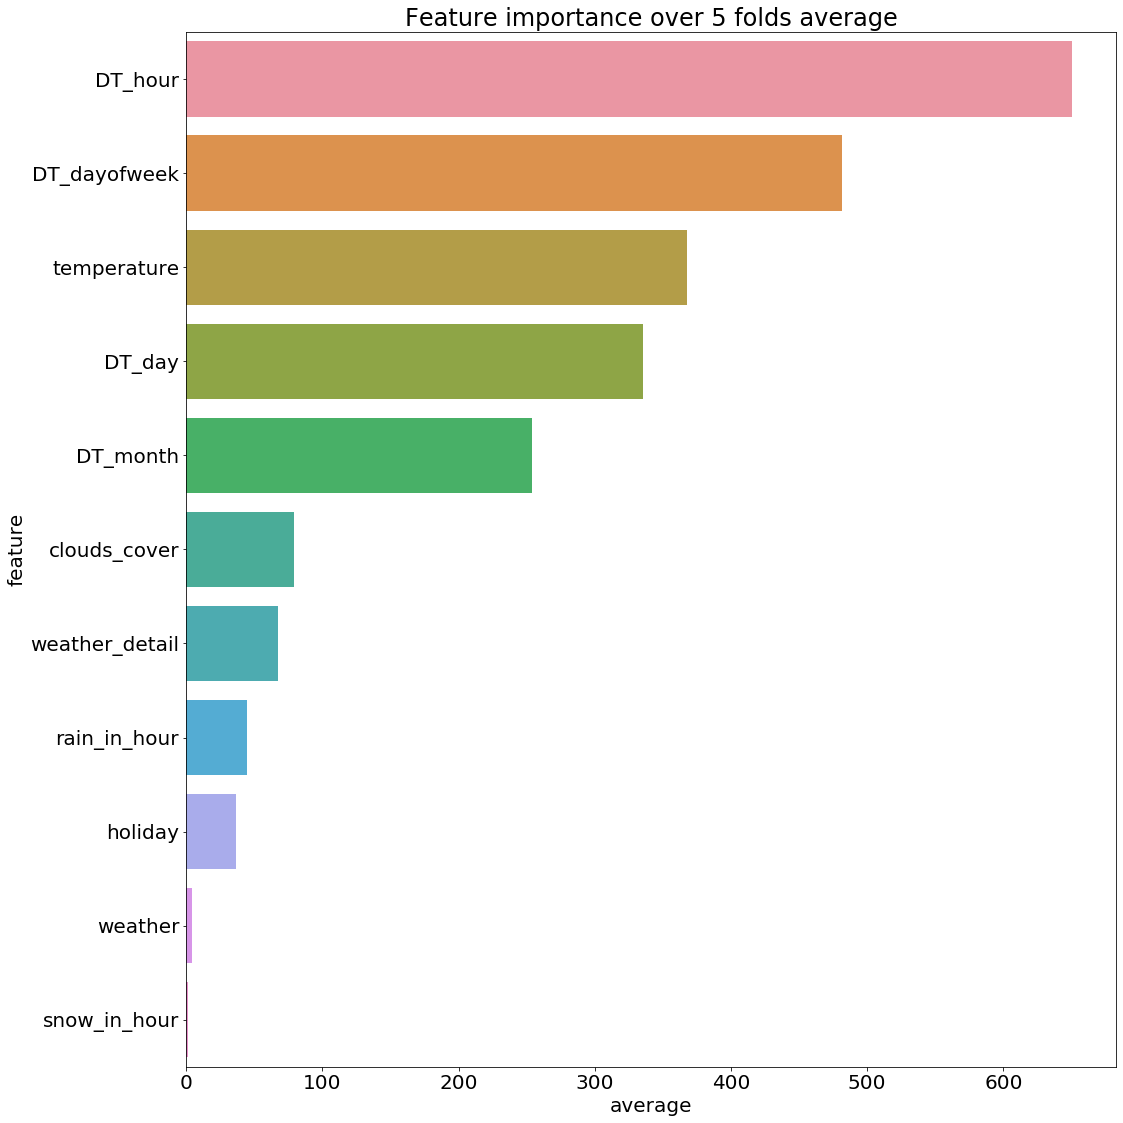

In [277]:
plt.rcParams['font.size'] = 20
feature_importance['average'] = feature_importance[[f'fold_{i + 1}' for i in range(kf.n_splits)]].mean(axis=1)
# feature_importance.to_csv(f'./outputs/feature_importances_{today}.csv')
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importance.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title(f'Feature importance over {kf.n_splits} folds average', )
plt.tight_layout()
plt.savefig(f'./result/FI_{score:.1f}.png', dpi=150)
#plt.savefig(f'./outputs/feature_importances_{today}_smirnov05', dpi=150)

In [264]:
rgr_all = lgb.LGBMRegressor(**params, num_boost_round=int(np.floor(rgr.best_iteration * 1.25)))
rgr_all.fit(X, y)

LGBMRegressor(bagging_fraction=0.6482201740533727, bagging_freq=4,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.9617297288610418, importance_type='split',
              lambda_l1=0.00021690634182527701, lambda_l2=0.0004967874048630971,
              learning_rate=0.1, max_depth=-1, metric='rmse',
              min_child_samples=8, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_boost_round=73, num_leaves=61,
              objective='regression', random_state=154, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [265]:
#XTest = np.float64(np.hstack([test_data.iloc[:,1:5],meta.iloc[len(train_data):,:]]))
#yHatTest = reg.predict(XTest)
np.savetxt(f'./result/1671261388_{score:.1f}.txt', rgr_all.predict(X_test).T) #save predictions in rows